# Generate skymaps with O2 posterior samples

This notebook demonstrates the method used to generate skymap plots for all the seven O2 Binary Black hole events presented in [arxiv:1811.09232](https://arxiv.org/abs/1811.09232). We generate fits files from the posterior samples of the sky location parameters from the parameter estimation runs, and plot 90% credible region contours of the sky locations on a Mollweide projection plot.

## Install ligo.skymap

In [89]:
# Please look at https://lscsoft.docs.ligo.org/ligo.skymap/quickstart/install.html for the requirements before installation

#!pip install ligo.skymap



## Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy
import h5py
import matplotlib.pyplot as plt
from ligo.skymap import io
from ligo.skymap import plot
from ligo.skymap.kde import Clustered2DSkyKDE
from ligo.skymap import postprocess
import healpy as hp
import itertools
from astropy.time import Time
from astropy import units as u
import json
from matplotlib import patches
from matplotlib import rcParams
rcParams['font.size'] = 14



## Data files

In [1]:
files = ['posteriors/GW170104/gw170104_posteriors_thinned.hdf', \
         'posteriors/GW170608/gw170608_posteriors_thinned.hdf', \
         'posteriors/GW170729/gw170729_posteriors_thinned.hdf', \
         'posteriors/GW170809/gw170809_posteriors_thinned.hdf', \
         'posteriors/GW170814/gw170814_posteriors_thinned.hdf', \
         'posteriors/GW170818/gw170818_posteriors_thinned.hdf', \
         'posteriors/GW170823/gw170823_posteriors_thinned.hdf']


labels = ["GW170104", "GW170608", "GW170729", "GW170809", "GW170814", "GW170818", "GW170823"]



## Read RA DEC posteriors fom PE runs and write fits files

In [ ]:
for filename, event in zip(files, labels):
    fp = h5py.File(filename, "r")
    ra = numpy.array(fp['samples']['ra'][:])
    dec = numpy.array(fp['samples']['dec'][:])
    ra_dec_points = numpy.column_stack((ra,dec))
    ra_dec_skypost = Clustered2DSkyKDE(ra_dec_points)
    hpmap = ra_dec_skypost.as_healpix()
    print("Done hpmap for {}".format(event))
    io.write_sky_map(event + 'skypost.fits.gz', hpmap, nest=True)
    print("Done write_sky_map for {}".format(event))

## Make a dictionary with the event names as keys and the fits filenames as items

In [5]:
fits_files = {}
for event in labels:
    fits_files.update({event: event + 'skypost.fits.gz'})

## Plot Fig. 3 of the paper : Probability distribution contours of sky locations on a Mollweide projection

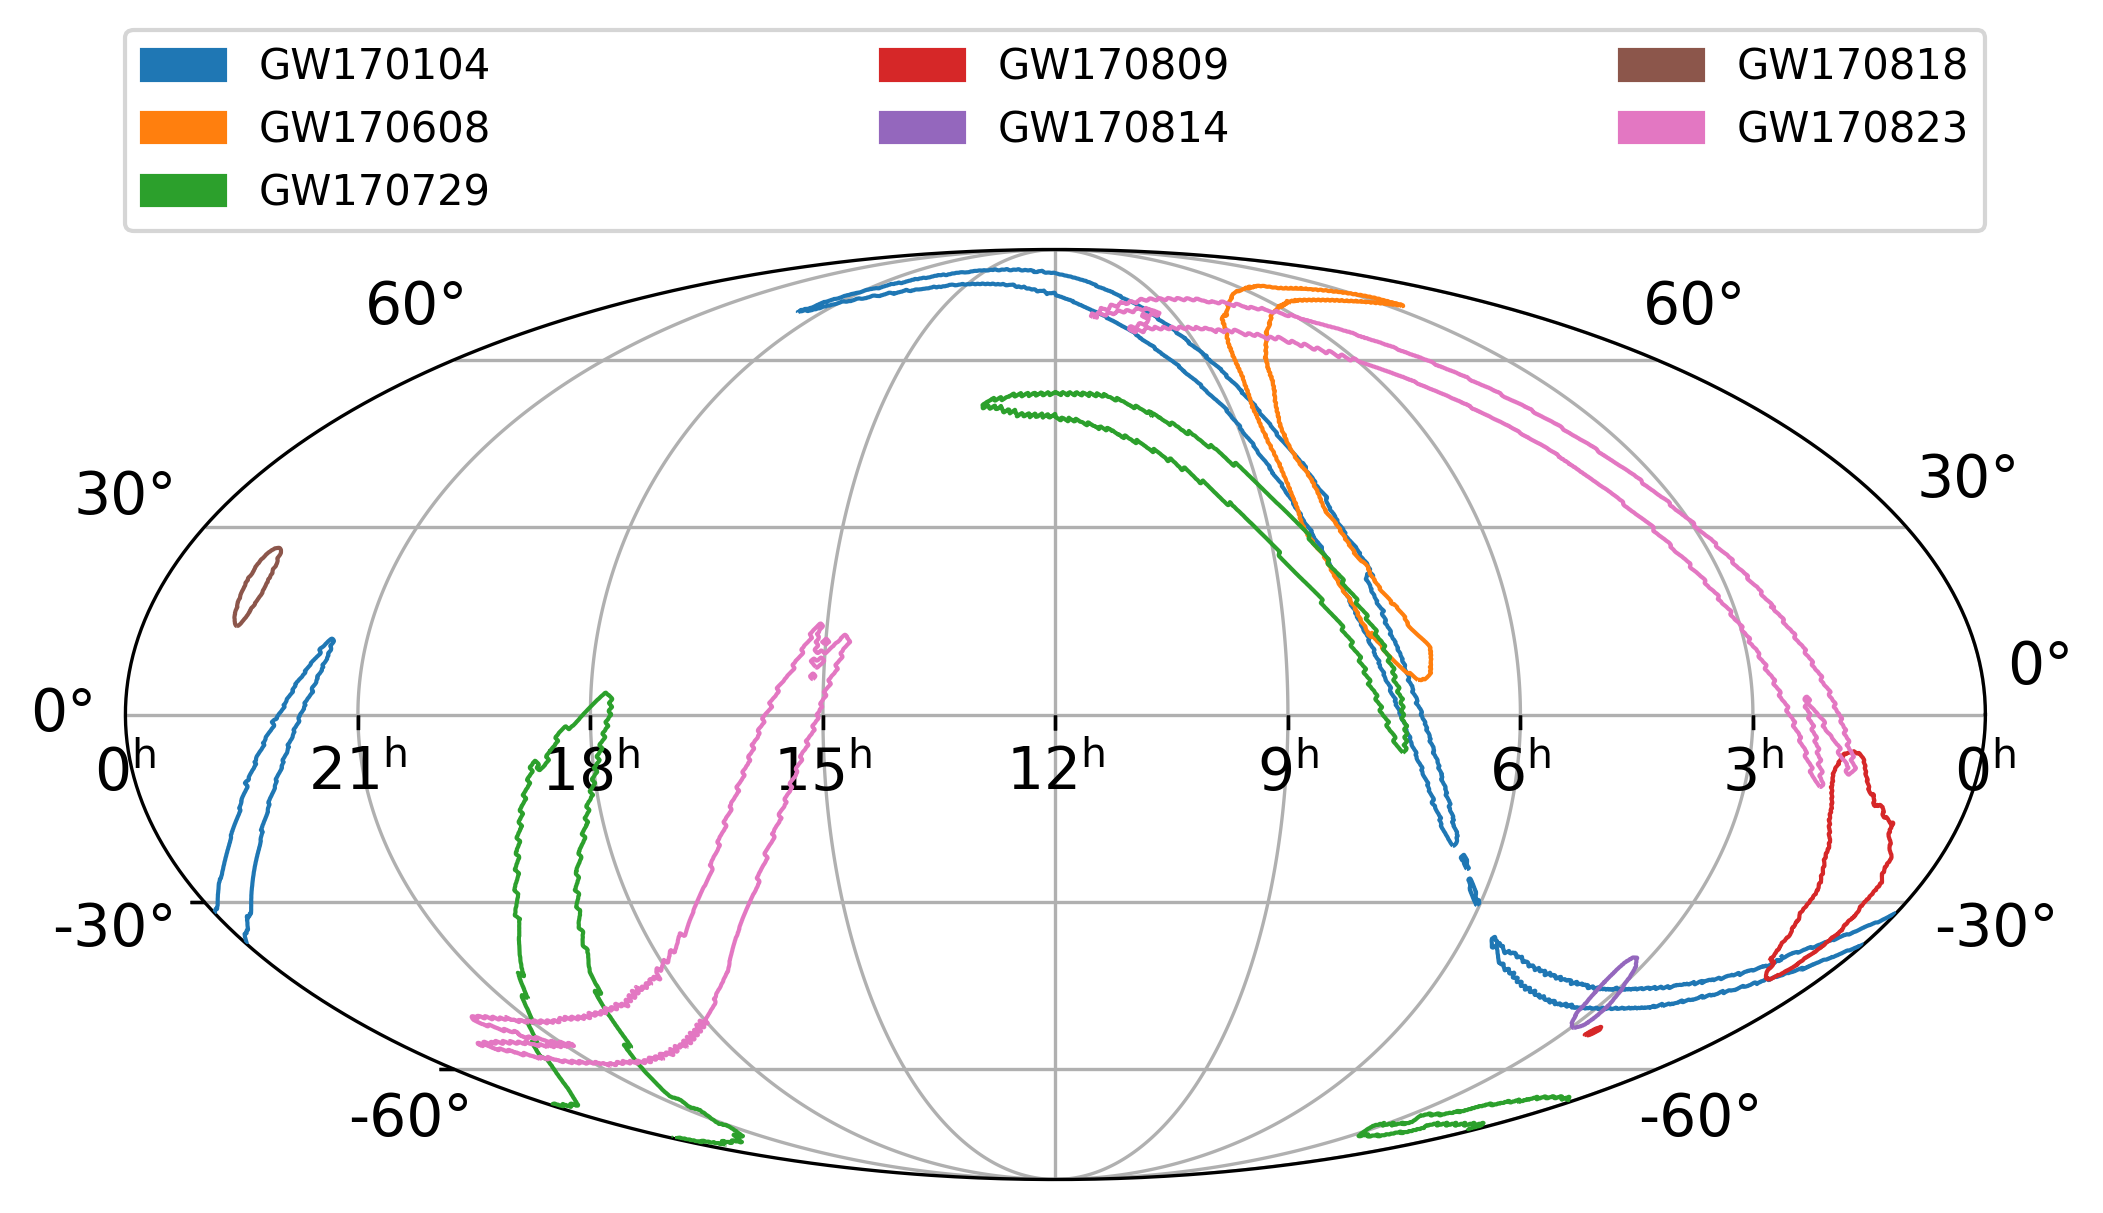

In [7]:
contour_percent=90
dpi=300
    
handles = []
colors = itertools.cycle(["C{}".format(i) for i in range(10)])    
fig = plt.figure(figsize=(8, 8), dpi=dpi)

# Set time
ax = fig.add_subplot(1,1,1,projection='astro hours mollweide')

# Plot contours
for event, fits_file in fits_files.items():
    color = next(colors)
    skymap, metadata = io.fits.read_sky_map(fits_file, nest=None)
    cls = 100 * postprocess.find_greedy_credible_levels(skymap)
    cs = ax.contour_hpx((cls, 'ICRS'), nested=metadata['nest'], colors=color, linewidths=1, levels=contour_percent)

    handles.append(patches.Patch(color=color, label=event))

ax.grid()


plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", 
              handles=handles, labels=fits_files.keys(), fontsize=10,
              mode="expand", borderaxespad=0, ncol=3)
plt.show()